<a href="https://colab.research.google.com/github/Ilvecho/Project_2/blob/main/P2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
A company is doing a marketing campaign to sell a short term financial tool.
We need to develop a model that predicts whether an individual will subscribe to the tool or not.

Available we have a 40'000 samples labeled dataset with mixed features: Categorical, Numerical and Binary.

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots

from google.colab import files
files.upload()
pass

Saving term-deposit-marketing-2020.csv to term-deposit-marketing-2020.csv


In [2]:
raw_data = pd.read_csv('term-deposit-marketing-2020.csv')

# Encode all the binary features (and the label) with numebrs instead of words
raw_data = raw_data.mask(raw_data == 'no', other=0)
raw_data = raw_data.mask(raw_data == 'yes', other=1)

spw = (labels == 0).sum() / labels.sum()

# bool variable needed later
age_grouped = False
duration_grouped = False
balance_grouped = False

# Missing values

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [ ]:
raw_data.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [ ]:
print(raw_data.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64


We have 40'000 samples, made of 13 features and 1 label.

The features have different data type -> we will need to convert some features in order to have consistent data type across all features.

At first look, it seems that there are no missing values.

In [ ]:
raw_data.head(15)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0
5,35,management,married,tertiary,0,231,1,0,unknown,5,may,139,1,0
6,28,management,single,tertiary,0,447,1,1,unknown,5,may,217,1,0
7,42,entrepreneur,divorced,tertiary,1,2,1,0,unknown,5,may,380,1,0
8,58,retired,married,primary,0,121,1,0,unknown,5,may,50,1,0
9,43,technician,single,secondary,0,593,1,0,unknown,5,may,55,1,0


However, by looking at the first samples, we notice that there are some values "unknown" -> there actually are missing values.

Let's see if there are other values equivalent to "missing".

Note that we should check categorical features only

In [ ]:
for key in raw_data.keys():

  if raw_data.loc[:, key].dtype == 'O':
    print('---------------------------------')
    print('Value counts for feature: ' + key)
    print(raw_data.loc[:, key].value_counts())
    print('+++++++++++++++++++++++++++++++++')

---------------------------------
Value counts for feature: job
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64
+++++++++++++++++++++++++++++++++
---------------------------------
Value counts for feature: marital
married     24386
single      10889
divorced     4725
Name: marital, dtype: int64
+++++++++++++++++++++++++++++++++
---------------------------------
Value counts for feature: education
secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64
+++++++++++++++++++++++++++++++++
---------------------------------
Value counts for feature: default
0    39191
1      809
Name: default, dtype: int64
+++++++++++++++++++++++++++++++++
---------------------------------
Value counts for feature: housing


From the print above, we can see that the only missing values are marked as Unknown.

We need to think about how to deal with missing values:
*   We could leave them missing (i.e. additional category 'unknown')
*   We could fill in with the most frequent value of the feature (risk of unbalancing the dataset)
*   We could remove the rows (risk of information loss)
*   We could build a predictor based on the remaining features.

# Label Balance

In [ ]:
raw_data.loc[raw_data['y'] == 'no', 'y'] = 0
raw_data.loc[raw_data['y'] == 'yes', 'y'] = 1

In [ ]:
print(raw_data['y'].value_counts())
print('Average probability of yes: ', raw_data['y'].sum() / raw_data.shape[0])

0    37104
1     2896
Name: y, dtype: int64
Average probability of yes:  0.0724


The labels of the dataset are **very unbalanced** with a ratio of almost 13:1 between No and Yes.

We will need to keep this in mind while developing the model, especially because the Yes are **more important** than the No

# Outliers

Let's see which data are outside 3 standard deviations (99,7%).

Note: **categorical** features cannot have outliers, hence we will check only the numeric features.
Note, the feature "day" is categorical even if its datatype is int.

In [ ]:
numerical_keys = ['age', 'balance', 'duration', 'campaign']

for key in numerical_keys:
# key = 'duration'
  mean = raw_data[key].mean()
  std = raw_data[key].std()

  tmp = raw_data.loc[raw_data[key] >= mean + 3* std, 'y']
  print('------------------')
  print(f'The number of outliers in feature {key} is: {tmp.shape[0]}')
  print(f'The probability of the outliers to say yes is: { tmp.sum() / tmp.shape[0]}')

------------------
The number of outliers in feature age is: 89
The probability of the outliers to say yes is: 0.449438202247191
------------------
The number of outliers in feature balance is: 673
The probability of the outliers to say yes is: 0.09212481426448738
------------------
The number of outliers in feature duration is: 865
The probability of the outliers to say yes is: 0.5988439306358382
------------------
The number of outliers in feature campaign is: 836
The probability of the outliers to say yes is: 0.03229665071770335


We see that there are few samples outside the 99.7%, especially for features balance, durtion and campaign.

Let's now analyze the distribution of the features, with an eye on the label as well

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

for key in numerical_keys:
  fig = px.histogram(raw_data, x=key, marginal='box', title='Distribution of attribute '+key) # color='y',
  fig.show()

1/ Feature 'age'
The distribution is quite wide, with a small number of outliers. By zooming in the outlier region, we notice that the ratio between yes and no is much higher than in the center of the distribution.

This could indicate that samples that are outliers in this feature have an higher probability of saying yes. We will **not remove** the outliers from this feature

2/ Feature 'balance'
The distribution of the feature is very narrow, with outlier tails on both sides.
The left outliers region is not particularly long, and it is mainly filled with 'no' samples -> we might remove the samples with balance lower than -1000. It also makes sense logically: a broke individual is not going to open a deposit.
The right region of outliers has two trends: in the first part (balance < 5000) we notice an increase of 'yes' samples, afterwards the outliers are mainly 'no'.

In this case, we might **keep only** the samples with balance between -1000 and 5000

3/ Feature 'duration'
Once again the distribution is quite narrow, with a long outlier tail on the positive side.
Looking at the boxplot we notice that the distribution of 'yes' is centered around an higher value than the 'no'. This makes sense logically: if a customer accept an offer, the phone call will be longer - while if they are not interested, the call will be much shorted.

After the value 2000 (i.e. 33 minutes), however, the number of samples drastically reduces -> the samples in this area are not statistically meaningful, so we are going to **remove** them.

4/ Feature 'campaign'
Also in this case the distribution is narrow with a long positive tail.
There is a very limited number of 'yes' samples with campaign > 10, while the 'no's are much more. We can draw two conclusions from this:

a) we shall **remove** the outliers with campaign > 10

b) we shall advise our client to avoid calling the same individual more than 10 times


# Correlation with Y

let's use frequency plots and probability of Yes to see if there are correlations between features/categories and the label

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots

for key in raw_data.keys():

  if key == 'y':
    break

  # Features of Type Object -> it will exclude 5 features: age, balance, day, duration and campain
  if raw_data.loc[:, key].dtype == 'O':

    # create the figure with two axes
    fig = subplots.make_subplots(specs=[[{"secondary_y": True}]])

    # Plot the frequency of each category
    value_count = raw_data.loc[:, key].value_counts(sort=False)
    fig.add_trace(
        go.Bar(x=value_count.keys(), y=value_count, name='Frequency', width=0.5),
        secondary_y=False)

    # Plot the probability of y for each category
    grp = raw_data.groupby(key, sort=False)
    prob_y = grp['y'].aggregate(np.mean)
    fig.add_trace(
        go.Scatter(x=prob_y.keys(), y=prob_y, name='Prob of Yes'),
        secondary_y=True)

    # Make the figure good and show it
    fig.update_yaxes(showgrid=False)
    fig.update_yaxes(range=[0.0, prob_y.max() * 1.1], secondary_y=True)
    fig.update_layout(title_text='Frequency plot for attribute '+ key + ' and probability of Yes for each category')
    fig.show()


Let's now address the features that were left out:

Age, balance, day, duration, campaign.

Age, day and campaign are not continuous variables, so we can use the same script as above. The only note to be mindful about is that the Bar plot will sort the values in ascending order. Hence, we need to set **sort=True** in the groupby function.

Balance and Duration, on the other hand, are continuous: we need to first quantize them with bins.

In [ ]:
for key in ['age', 'day', 'campaign']:
  # create the figure with two axes
  fig = subplots.make_subplots(specs=[[{"secondary_y": True}]])

  # Plot the frequency of each category
  value_count = raw_data.loc[:, key].value_counts(sort=False)
  fig.add_trace(
      go.Bar(x=value_count.keys(), y=value_count, name='Frequency', width=0.5),
      secondary_y=False)

  # Plot the probability of y for each category
  grp = raw_data.groupby(key, sort=True)
  prob_y = grp['y'].aggregate(np.mean)
  fig.add_trace(
      go.Scatter(x=prob_y.keys(), y=prob_y, name='Prob of Yes', mode='lines+markers'),
      secondary_y=True)

  # Make the figure good and show it
  fig.update_yaxes(showgrid=False)
  fig.update_layout(title_text='Frequency plot for attribute '+ key + ' and probability of Yes for each category')
  fig.show()

We use the same script as above, simply we do a quantization step beforehand

In [ ]:
quant_data = raw_data.copy()

for key in ['balance', 'duration']:

  quant_data[key], bins = pd.cut(raw_data[key], bins=200, retbins=True)

    # create the figure with two axes
  fig = subplots.make_subplots(specs=[[{"secondary_y": True}]])

  # Plot the frequency of each category
  value_count = quant_data.loc[:, key].value_counts(sort=False)
  fig.add_trace(
      go.Bar(x=value_count.keys().astype('str'), y=value_count, name='Frequency', width=0.5),
      secondary_y=False)

  # Plot the probability of y for each category
  grp = quant_data.groupby(key, sort=True)
  prob_y = grp['y'].aggregate(np.mean)
  fig.add_trace(
      go.Scatter(x=prob_y.keys().astype('str'), y=prob_y, name='Prob of Yes', mode='lines+markers'),
      secondary_y=True)

  # Make the figure good and show it
  fig.update_yaxes(showgrid=False)
  fig.update_layout(title_text='Frequency plot for attribute '+ key + ' and probability of Yes for each category')
  fig.show()

1/ Categorical features (including 'day')

We observe some correlation between different categories and the probability of Yes. Hopefully, the model will identify and exploit such correlation

2/ Feature 'age'

We notice that in the center of the distribution, the probability of Yes is more or less constant -> we can consider to group together some values to reduce the number of possible values.
In the outlier region, on the other hand, we observe and increase in the probability of Yes. However, after the value 80 the probability is very scattered -> the number of samples in this region is extremely low, we might consider to cut them off

3/ Feature 'campaign'

In the outlier analysis, we suggested to remove the samples with campaign > 10. Looking at the correlation, we notice that the probability of Yes drops after 10, with some peaks that are due to the very limited number of samples.
In conclusion, the correlation analysis corroborates the conclusion of the outliers analysis

4/ Feature 'balance'

Once again, in the regions identified as outliers the probability of Yes is very low, with some peaks due to the low number of samples.
However, we notice that this behavior starts slightly after the region previously identified. Hence, we might consider 10000 instead of 5000 as upper bound.

5/ Feature 'duration'

We observe that the probability of Yes increases with the increase of the duration. However, once again, after some point the trend disrupts because of the limited number of samples.
Hence, also this analysis confirms that we shall remove the outliers with value above 2000

# Exploratory Data Analysis conclusions

**Missing values**:

There are missing values in 'job', 'education', 'contact'. Options:
- substitute missing values with the most frequent one
- leave the values as missing -> additional category

We tested both options and the highest performance was obtained leaving the values as 'unknown' (additional category)

**Label balance**:

We notice that the dataset is highly unbalanced toward negative (13:1)
- Use XGBoost parameter scale_pos_weight
- Undersample/Oversample the database to balance it -> in this case is not a viable option because the real data distribution is likely to be well represented by the samples

**Outliers**:

There are few features with outlier values.
At first we considered (and tested) the exclusion of the outliers:
- balance: keep [-1000, 5000] or [-1000, 10000]
- duration: keep [0, 2000]
- campaign: keep [0, 10]
- age: might consider to keep [0, 80]

However, then we opted for another solution:
We engineered the features, binning the values so that each new bin was represented by a statistically meaningful number of samples

**Correlation**:

We observe some kind of correlation between the outcome and the categorical featues - hopefully the model will indentify and exploit such correlation.
Furthermore, this analysis for the numerical features corroborates the conclusions of the Ouliers analysis.

The correlation analysis corroborated the idea of engineering the features to obtain more clear trends in each feature

# Feature engineering - month

First we try and drop the feature

In [ ]:
modified_data = raw_data.drop('month', axis=1)
modified_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,198,1,0


then, we try to group the feature in a logical way

In [3]:
modified_data = raw_data.copy()

seasons = {
    'jan': 'winter',
    'feb': 'winter',
    'mar': 'spring',
    'apr': 'spring',
    'may': 'spring',
    'jun': 'summer',
    'jul': 'summer',
    'aug': 'summer',
    'sep': 'fall',
    'oct': 'fall',
    'nov': 'fall',
    'dec': 'winter'
}

for key in seasons.keys():
  modified_data = modified_data.mask(modified_data == key, other=seasons[key])

modified_data.month.value_counts()

spring    16508
summer    16329
fall       3678
winter     3485
Name: month, dtype: int64

In [ ]:
has_prediction = False
key = 'month'

# create the figure with two axes
fig = subplots.make_subplots(specs=[[{"secondary_y": True}]])

# Plot the frequency of each category
value_count = modified_data.loc[:, key].value_counts(sort=False)
fig.add_trace(
    go.Bar(x=value_count.keys(), y=value_count, name='Frequency', width=0.5),
    secondary_y=False)

# Plot the PREDICTED probability of y for each category
if has_prediction:
  # create the dataframe with the predictions (both train and test)
  # note that this dataframe has the same index as the other
  pred_data = pd.concat([X_train, X_test])
  pred_data['y_pred'] = np.concatenate((pred_train, pred_test))

  # we use the index to add the predicted value to the proper sample
  modified_data['y_pred'] = pred_data['y_pred'].sort_index()

# Plot the probability of y for each category
grp = modified_data.groupby(key, sort=False)
prob_y = grp['y'].aggregate(np.mean)
fig.add_trace(
    go.Scatter(x=prob_y.keys(), y=prob_y, name='Prob of Yes'),
    secondary_y=True)

# Plot the PREDICTED probability of y for each category
if has_prediction:
  pred_prob_y = grp['y_pred'].aggregate(np.mean)
  fig.add_trace(
      go.Scatter(x=pred_prob_y.keys(), y=pred_prob_y, name='Predicted Prob of Yes'),
      secondary_y=True)

  # IMPORTANT: remove the column from the modified data DF
  modified_data.drop('y_pred', axis=1, inplace=True)

# Make the figure good and show it
fig.update_yaxes(showgrid=False)
if has_prediction:
  limit = pd.concat((prob_y, pred_prob_y)).max()
  fig.update_yaxes(range=[0.0, limit * 1.1], secondary_y=True)
else:
  fig.update_yaxes(range=[0.0, prob_y.max() * 1.1], secondary_y=True)
fig.update_layout(title_text='Frequency plot for attribute '+ key + ' and probability of Yes for each category')
fig.show()

# Feature engineering - age

The age is a continous variable: we group it in bins, so that each bin has a meaningful number of samples

In [4]:
# Remember that if the months are groupped, then the modified_data DataFrame already exists and should be used
# modified_data = raw_data.copy()
age_bins = [0, 29, 34, 39, 44, 49, 54, 100]

modified_data['age'] = pd.cut(raw_data['age'], bins=age_bins).astype('str')
age_grouped = True

In [ ]:
has_prediction = False
key = 'age'
order =["(0, 29]", "(29, 34]", "(34, 39]", "(39, 44]", "(44, 49]", "(49, 54]", "(54, 100]"]

# reindex the dataframe to have the graphs in the proper order
modified_data = modified_data.set_index(key).loc[order].reset_index()

# create the figure with two axes
fig = subplots.make_subplots(specs=[[{"secondary_y": True}]])

# Plot the frequency of each category
value_count = modified_data.loc[:, key].value_counts(sort=False)
fig.add_trace(
    go.Bar(x=value_count.keys(), y=value_count, name='Frequency', width=0.5),
    secondary_y=False)

# fig.update_xaxes(categoryorder='array', categoryarray=order)

# Plot the PREDICTED probability of y for each category
if has_prediction:
  # create the dataframe with the predictions (both train and test)
  # note that this dataframe has the same index as the other
  pred_data = pd.concat([X_train, X_test])
  pred_data['y_pred'] = np.concatenate((pred_train, pred_test))

  # we use the index to add the predicted value to the proper sample
  modified_data['y_pred'] = pred_data['y_pred'].sort_index()

# Plot the probability of y for each category
grp = modified_data.groupby(key, sort=False)
prob_y = grp['y'].aggregate(np.mean)
fig.add_trace(
    go.Scatter(x=prob_y.keys(), y=prob_y, name='Prob of Yes'),
    secondary_y=True)

# Plot the PREDICTED probability of y for each category
if has_prediction:
  pred_prob_y = grp['y_pred'].aggregate(np.mean)
  fig.add_trace(
      go.Scatter(x=pred_prob_y.keys(), y=pred_prob_y, name='Predicted Prob of Yes'),
      secondary_y=True)

  # IMPORTANT: remove the column from the modified data DF
  modified_data.drop('y_pred', axis=1, inplace=True)

# Make the figure good and show it
fig.update_yaxes(showgrid=False)
if has_prediction:
  limit = pd.concat((prob_y, pred_prob_y)).max()
  fig.update_yaxes(range=[0.0, limit * 1.1], secondary_y=True)
else:
  fig.update_yaxes(range=[0.0, prob_y.max() * 1.1], secondary_y=True)
fig.update_layout(title_text='Frequency plot for attribute '+ key + ' and probability of Yes for each category')
fig.show()

# Feature engineering - campaign

In [5]:
# Remember that if months and/or age are groupped, then the modified_data DataFrame already exists and should be used
# modified_data = raw_data.copy()

modified_data.campaign[modified_data.campaign > 6] = 7

<ipython-input-5-5422755eef14>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_data.campaign[modified_data.campaign > 6] = 7


Plotting

In [ ]:
has_prediction = False
key='campaign'

# create the dataframe with the predictions (both train and test)
if has_prediction:
  # create the dataframe with the predictions (both train and test)
  # note that this dataframe has the same index as the other
  pred_data = pd.concat([X_train, X_test])
  pred_data['y_pred'] = np.concatenate((pred_train, pred_test))

  # we use the index to add the predicted value to the proper sample
  modified_data['y_pred'] = pred_data['y_pred'].sort_index()

modified_data = modified_data.sort_values(by=[key], axis=0).reset_index()

# the line above creates a new column 'index' - we remove it because it's not needed
modified_data.drop('index', axis=1, inplace=True)

# create the figure with two axes
fig = subplots.make_subplots(specs=[[{"secondary_y": True}]])

# Plot the frequency of each category
value_count = modified_data.loc[:, key].value_counts(sort=False)
fig.add_trace(
    go.Bar(x=value_count.keys(), y=value_count, name='Frequency', width=0.5),
    secondary_y=False)

# fig.update_xaxes(categoryorder='array', categoryarray=order)

# Plot the probability of y for each category
grp = modified_data.groupby(key, sort=False)
prob_y = grp['y'].aggregate(np.mean)
fig.add_trace(
    go.Scatter(x=prob_y.keys(), y=prob_y, name='Prob of Yes'),
    secondary_y=True)

# Plot the PREDICTED probability of y for each category
if has_prediction:
  pred_prob_y = grp['y_pred'].aggregate(np.mean)
  fig.add_trace(
      go.Scatter(x=pred_prob_y.keys(), y=pred_prob_y, name='Predicted Prob of Yes'),
      secondary_y=True)

  # IMPORTANT: remove the column from the modified data DF
  modified_data.drop('y_pred', axis=1, inplace=True)

# Make the figure good and show it
fig.update_yaxes(showgrid=False)

# x-ticks preparations
tickvals=np.arange(1, 8)
ticktext=['1', '2', '3', '4', '5', '6', '>6']

# update tickmarks
fig.update_xaxes(tickmode = 'array', tickvals = tickvals, ticktext=ticktext)
if has_prediction:
  limit = pd.concat((prob_y, pred_prob_y)).max()
  fig.update_yaxes(range=[0.0, limit * 1.1], secondary_y=True)
else:
  fig.update_yaxes(range=[0.0, prob_y.max() * 1.1], secondary_y=True)
fig.update_layout(title_text='Frequency plot for attribute '+ key + ' and probability of Yes for each category')
fig.show()

# Feature engineering - day

In [6]:
day_type = {
    'payday': [1, 10, 22, 30, 31],
    'after_payday': [2, 3, 4, 11, 12, 13, 23, 24, 25],
    'non_payday': [5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29]
}

for key in day_type.keys():
  for day in day_type[key]:
    modified_data.day = modified_data.day.mask(modified_data.day == day, other=key)

modified_data.day.value_counts()

non_payday      27717
after_payday     8922
payday           3361
Name: day, dtype: int64

In [ ]:
has_prediction = False
key = 'day'

# create the dataframe with the predictions (both train and test)
if has_prediction:
  # create the dataframe with the predictions (both train and test)
  # note that this dataframe has the same index as the other
  pred_data = pd.concat([X_train, X_test])
  pred_data['y_pred'] = np.concatenate((pred_train, pred_test))

  # we use the index to add the predicted value to the proper sample
  modified_data['y_pred'] = pred_data['y_pred'].sort_index()

# create the figure with two axes
fig = subplots.make_subplots(specs=[[{"secondary_y": True}]])

# Plot the frequency of each category
value_count = modified_data.loc[:, key].value_counts(sort=False)
fig.add_trace(
    go.Bar(x=value_count.keys(), y=value_count, name='Frequency', width=0.5),
    secondary_y=False)

# Plot the probability of y for each category
grp = modified_data.groupby(key, sort=False)
prob_y = grp['y'].aggregate(np.mean)
fig.add_trace(
    go.Scatter(x=prob_y.keys(), y=prob_y, name='Prob of Yes'),
    secondary_y=True)

# Plot the PREDICTED probability of y for each category
if has_prediction:
  pred_prob_y = grp['y_pred'].aggregate(np.mean)
  fig.add_trace(
      go.Scatter(x=pred_prob_y.keys(), y=pred_prob_y, name='Predicted Prob of Yes'),
      secondary_y=True)

  # IMPORTANT: remove the column from the modified data DF
  modified_data.drop('y_pred', axis=1, inplace=True)

# Make the figure good and show it
fig.update_yaxes(showgrid=False)
if has_prediction:
  limit = pd.concat((prob_y, pred_prob_y)).max()
  fig.update_yaxes(range=[0.0, limit * 1.1], secondary_y=True)
else:
  fig.update_yaxes(range=[0.0, prob_y.max() * 1.1], secondary_y=True)
fig.update_layout(title_text='Frequency plot for attribute '+ key + ' and probability of Yes for each category')
fig.show()

# Feature engineering - duration

In [7]:
# Remember that if months and/or age are groupped, then the modified_data DataFrame already exists and should be used
# modified_data = raw_data.copy()
# modified_data.duration = raw_data.duration

modified_data.duration[modified_data.duration > 840] = 840

# sort the rows based on duration, just for plotting purposes
modified_data.sort_values(by='duration', axis=0, inplace=True)

# perform the binning
modified_data['duration'] = pd.cut(modified_data['duration'], bins=7).astype('str')
duration_grouped = True

<ipython-input-7-675a6a37caee>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_data.duration[modified_data.duration > 840] = 840


In [ ]:
has_prediction = False
key = 'duration'

# create the figure with two axes
fig = subplots.make_subplots(specs=[[{"secondary_y": True}]])

# Plot the frequency of each category
value_count = modified_data.loc[:, key].value_counts(sort=False)
fig.add_trace(
    go.Bar(x=value_count.keys(), y=value_count, name='Frequency', width=0.5),
    secondary_y=False)

# Plot the PREDICTED probability of y for each category
if has_prediction:
  # create the dataframe with the predictions (both train and test)
  # note that this dataframe has the same index as the other
  pred_data = pd.concat([X_train, X_test])
  pred_data['y_pred'] = np.concatenate((pred_train, pred_test))

  # we use the index to add the predicted value to the proper sample
  modified_data['y_pred'] = pred_data['y_pred'].sort_index()

# Plot the probability of y for each category
grp = modified_data.groupby(key, sort=False)
prob_y = grp['y'].aggregate(np.mean)
fig.add_trace(
    go.Scatter(x=prob_y.keys(), y=prob_y, name='Prob of Yes'),
    secondary_y=True)

# Plot the PREDICTED probability of y for each category
if has_prediction:
  pred_prob_y = grp['y_pred'].aggregate(np.mean)
  fig.add_trace(
      go.Scatter(x=pred_prob_y.keys(), y=pred_prob_y, name='Predicted Prob of Yes'),
      secondary_y=True)

  # IMPORTANT: remove the column from the modified data DF
  modified_data.drop('y_pred', axis=1, inplace=True)

# Make the figure good and show it
fig.update_yaxes(showgrid=False)
if has_prediction:
  limit = pd.concat((prob_y, pred_prob_y)).max()
  fig.update_yaxes(range=[0.0, limit * 1.1], secondary_y=True)
else:
  fig.update_yaxes(range=[0.0, prob_y.max() * 1.1], secondary_y=True)
fig.update_layout(title_text='Frequency plot for attribute '+ key + ' and probability of Yes for each category')
fig.show()

# Feature engineering - balance

We try two binning strategies:
- <-1000, (-1000.0, 0.0], (0.0, 1000.0], (1000.0, 2000.0], (2000.0, 3000.0], (3000.0, 4000.0], >4000
- <-1000, (-1000.0, 0.0], (0.0, 1000.0], (1000.0, 2000.0], (2000.0, 3000.0], (3000.0, 4000.0], (4000.0, 5000.0], (5000.0, 10000.0], >10000.0

The latter is more granular on the high end of the interval.

We observe more or less the same trend in the data:
the probability of Yes increases with the increase of the balance, up until 4000. Then it slightly diminishes.

However, the second binning strategy causes a small performance drop, and the model is not able to fully pick up the trend in the high end of the interval (probably due to the limited number of samples).
Hence, we are going to stick with the first binning strategy

In [8]:
# modified_data = raw_data.copy()
# modified_data.balance = raw_data.balance.copy()

modified_data.balance[modified_data.balance > 5000] = 5000
modified_data.balance[modified_data.balance < -2000] = -2000

# bin_extrema = [-2010.0, -1000.0, 0.0, 1000.0, 2000.0, 3000.0, 4000.0, 5000.0, 10000.0, 500000.0]

# sort the rows based on duration, just for plotting purposes
modified_data.sort_values(by='balance', axis=0, inplace=True)

# perform the binning
modified_data['balance'] = pd.cut(modified_data['balance'], bins=7).astype('str')
balance_grouped = True

<ipython-input-8-731c9f72e3b6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_data.balance[modified_data.balance > 5000] = 5000
<ipython-input-8-731c9f72e3b6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_data.balance[modified_data.balance < -2000] = -2000


In [ ]:
has_prediction = False
key = 'balance'

# create the figure with two axes
fig = subplots.make_subplots(specs=[[{"secondary_y": True}]])

# Plot the frequency of each category
value_count = modified_data.loc[:, key].value_counts(sort=False)
fig.add_trace(
    go.Bar(x=value_count.keys(), y=value_count, name='Frequency', width=0.5),
    secondary_y=False)

# Plot the PREDICTED probability of y for each category
if has_prediction:
  # create the dataframe with the predictions (both train and test)
  # note that this dataframe has the same index as the other
  pred_data = pd.concat([X_train, X_test])
  pred_data['y_pred'] = np.concatenate((pred_train, pred_test))

  # we use the index to add the predicted value to the proper sample
  modified_data['y_pred'] = pred_data['y_pred'].sort_index()

# Plot the probability of y for each category
grp = modified_data.groupby(key, sort=False)
prob_y = grp['y'].aggregate(np.mean)
fig.add_trace(
    go.Scatter(x=prob_y.keys(), y=prob_y, name='Prob of Yes'),
    secondary_y=True)

# Plot the PREDICTED probability of y for each category
if has_prediction:
  pred_prob_y = grp['y_pred'].aggregate(np.mean)
  fig.add_trace(
      go.Scatter(x=pred_prob_y.keys(), y=pred_prob_y, name='Predicted Prob of Yes'),
      secondary_y=True)

  # IMPORTANT: remove the column from the modified data DF
  modified_data.drop('y_pred', axis=1, inplace=True)


tickvals=np.arange(0, 8)
ticktext=['< -1000', '(-1000.0, 0.0]', '(0.0, 1000.0]', '(1000.0, 2000.0]', '(2000.0, 3000.0]', '(3000.0, 4000.0]','> 4000.0']

# tickvals=np.arange(0, 10)
# ticktext=['<-1000', '(-1000.0, 0.0]', '(0.0, 1000.0]', '(1000.0, 2000.0]', '(2000.0, 3000.0]', '(3000.0, 4000.0]', '(4000.0, 5000.0]', '(5000.0, 10000.0]', '>10000.0']

# update tickmarks
fig.update_xaxes(tickmode = 'array', tickvals = tickvals, ticktext=ticktext)

# Make the figure good and show it
fig.update_yaxes(showgrid=False)
if has_prediction:
  limit = pd.concat((prob_y, pred_prob_y)).max()
  fig.update_yaxes(range=[0.0, limit * 1.1], secondary_y=True)
else:
  fig.update_yaxes(range=[0.0, prob_y.max() * 1.1], secondary_y=True)
fig.update_layout(title_text='Frequency plot for attribute '+ key + ' and probability of Yes for each category')
fig.show()

# Feature engineering - job

In [ ]:
temp_copy = modified_data.copy()

In [9]:
# modified_data = temp_copy.copy()

jobs = {
    'housemaid': 'low skills',
    'blue-collar': 'low skills',
    'admin': 'business jobs',
    'services': 'business jobs',
    'entrepreneur': 'business jobs',
    'self-employed': 'variable income',
    'retired': 'variable income',
    'unemployed': 'variable income',
    'student': 'variable income',
}

for key in jobs.keys():
  modified_data = modified_data.mask(modified_data == key, other=jobs[key])

modified_data.job.value_counts()

low skills         10470
business jobs       9798
management          8166
technician          6852
variable income     4479
unknown              235
Name: job, dtype: int64

In [ ]:
has_prediction = False
key = 'job'

# create the figure with two axes
fig = subplots.make_subplots(specs=[[{"secondary_y": True}]])

# Plot the frequency of each category
value_count = modified_data.loc[:, key].value_counts(sort=False)
fig.add_trace(
    go.Bar(x=value_count.keys(), y=value_count, name='Frequency', width=0.5),
    secondary_y=False)

# Plot the PREDICTED probability of y for each category
if has_prediction:
  # create the dataframe with the predictions (both train and test)
  # note that this dataframe has the same index as the other
  pred_data = pd.concat([X_train, X_test])
  pred_data['y_pred'] = np.concatenate((pred_train, pred_test))

  # we use the index to add the predicted value to the proper sample
  modified_data['y_pred'] = pred_data['y_pred'].sort_index()

# Plot the probability of y for each category
grp = modified_data.groupby(key, sort=False)
prob_y = grp['y'].aggregate(np.mean)
fig.add_trace(
    go.Scatter(x=prob_y.keys(), y=prob_y, name='Prob of Yes'),
    secondary_y=True)

# Plot the PREDICTED probability of y for each category
if has_prediction:
  pred_prob_y = grp['y_pred'].aggregate(np.mean)
  fig.add_trace(
      go.Scatter(x=pred_prob_y.keys(), y=pred_prob_y, name='Predicted Prob of Yes'),
      secondary_y=True)

  # IMPORTANT: remove the column from the modified data DF
  modified_data.drop('y_pred', axis=1, inplace=True)

# Make the figure good and show it
fig.update_yaxes(showgrid=False)
fig.update_layout(title_text='Frequency plot for attribute '+ key + ' and probability of Yes for each category')
fig.show()

# Features engineering conclusions
Looking at the probability graphs for each feature, we see some trends that could translate in suggestions for the customer:
- Month: conduct the marketing campaign during winter and spring. Avoid the summer months.
- Age: focus the campaigns on younger people (up to 30-35 years of age). It would also be interesting to target more elderly (>60 yo): the few samples available show an high probability of success.
- Campaign: the higher the number of campaign, the lower is the probability of success -> instead of targeting the same individual over and over, reach out to new individuals
- Day: conduct the campains on pay days and the days immediately after since they yield higher probability of success
- Duration: as expected, the longer is the call, the higher is the probability of success
- Balance: as expected, the higher the balance and the higher is the probability of success. However, after the 4000 threshold, the probability of Yes slightly reduces


In any case, these are preliminary conclusions.
Once we develop the model, we can use the partial dependence plot to validate out conclusions.

# Encoding

Now we need to encode the categorical features & the label from string to numbers.
We will use sklearn preprocessing One Hot Encoder function.

Note: we insert the one hot encoding as a **list** in the corresponding column

In [10]:
data = modified_data.copy()

numerical_keys = ['campaign', 'loan', 'housing', 'default', 'y']
# month_categories = [['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']]

# perform the encoding:
for key in modified_data.keys():
# key = 'job'

  # age is a numerical feature, but if we engineered it, it is categorical so it needs to be encoded
  # however, we need to use a different encoder as the order of the categories matters
  if key == 'age':
    if not age_grouped:
      continue

    else:
      age_categories = [["(0, 29]", "(29, 34]", "(34, 39]", "(39, 44]", "(44, 49]", "(49, 54]", "(54, 100]"]]

      encoder = preprocessing.OrdinalEncoder(categories=age_categories)

      input = modified_data.loc[:, key].values.reshape(-1, 1)
      output = encoder.fit_transform(input)

      data['age'] = output
      continue

  # Duration is a numerical feature, but if we engineered it, it is categorical so it needs to be encoded
  # however, we need to use a different encoder as the order of the categories matters
  if key == 'duration':
    if not duration_grouped:
      continue

    else:
      duration_categories = [['(-0.84, 120.0]', '(120.0, 240.0]', '(240.0, 360.0]', '(360.0, 480.0]', '(480.0, 600.0]', '(600.0, 720.0]', '(720.0, 840.0]']]
      # duration_categories = [['(-0.9, 60.0]', '(120.0, 180.0]', '(180.0, 240.0]', '(240.0, 300.0]', '(300.0, 360.0]', '(360.0, 420.0]', '(420.0, 480.0]', '(480.0, 540.0]', '(540.0, 600.0]',
      #                         '(60.0, 120.0]', '(600.0, 660.0]', '(660.0, 720.0]', '(720.0, 780.0]', '(780.0, 840.0]', '(840.0, 900.0]']]

      encoder = preprocessing.OrdinalEncoder(categories=duration_categories)

      input = modified_data.loc[:, key].values.reshape(-1, 1)
      output = encoder.fit_transform(input)

      data['duration'] = output
      continue

  # Balance is a numerical feature, but if we engineered it, it is categorical so it needs to be encoded
  # however, we need to use a different encoder as the order of the categories matters
  if key == 'balance':
    if not balance_grouped:
      continue

    else:
      balance_categories = [['(-2007.0, -1000.0]', '(-1000.0, 0.0]', '(0.0, 1000.0]', '(1000.0, 2000.0]', '(2000.0, 3000.0]', '(3000.0, 4000.0]', '(4000.0, 5000.0]']]
      # balance_categories = [['(-2010.0, -1000.0]', '(-1000.0, 0.0]', '(0.0, 1000.0]', '(1000.0, 2000.0]', '(2000.0, 3000.0]', '(3000.0, 4000.0]', '(4000.0, 5000.0]', '(5000.0, 5010.0]']]

      encoder = preprocessing.OrdinalEncoder(categories=balance_categories)

      input = modified_data.loc[:, key].values.reshape(-1, 1)
      output = encoder.fit_transform(input)

      data['balance'] = output
      continue

  # Skip numerical features
  if key in numerical_keys:
    continue

  # We want the months to be ordered, so we pass the categories
  # NOTE: if the months are grouped by season, then this is not needed
  # elif key == 'month':
  #   encoder = preprocessing.OneHotEncoder(categories=month_categories, sparse_output=False, handle_unknown='error')

  # Else, we let the function do its magic
  else:
    encoder = preprocessing.OneHotEncoder(sparse_output=False, handle_unknown='error')

  input = modified_data.loc[:, key].values.reshape(-1, 1)
  output = encoder.fit_transform(input)
  print(key)

  # we want to create one new column for each category of the feature:
  # First we create the column names as "feature - category"
  new_col_names = []
  for cat in encoder.categories_[0]:
    new_col_names.append(key + ' - ' + str(cat))

  # then we create a temporary dataframe with the encodings and the new column names
  new_cols = pd.DataFrame(output, columns=new_col_names)

  # then we drop the original feature, and add the One Hot encoding equivalent
  # with this approach, we don't need to save the encodings - they are embedded in the column names
  tmp = data.drop(key, axis=1)
  data = pd.concat([tmp, new_cols], axis=1)


job
marital
education
contact
day
month


In [11]:
data.keys()

Index(['age', 'default', 'balance', 'housing', 'loan', 'duration', 'campaign',
       'y', 'job - business jobs', 'job - low skills', 'job - management',
       'job - technician', 'job - unknown', 'job - variable income',
       'marital - divorced', 'marital - married', 'marital - single',
       'education - primary', 'education - secondary', 'education - tertiary',
       'education - unknown', 'contact - cellular', 'contact - telephone',
       'contact - unknown', 'day - after_payday', 'day - non_payday',
       'day - payday', 'month - fall', 'month - spring', 'month - summer',
       'month - winter'],
      dtype='object')

# Labels extraction

In [12]:
# the reset index function adds a new column -> we need to drop it
# drop index needed when we remove the outliers
# data.drop('index', axis=1, inplace=True)
attributes = data.drop('y', axis=1)
labels = data['y']

# Note that labels have dtype=object, while we want int.
# So, we need to perform a quick casting with pandas native function to_numeric()
labels = pd.to_numeric(labels)

# We need to do the same for the boolean features default, housing and loan
attributes.default = pd.to_numeric(attributes.default)
attributes.loan = pd.to_numeric(attributes.loan)
attributes.housing = pd.to_numeric(attributes.housing)

# Model

This is a classification problem, so we can use **XGBoost** as a model.

This time the database is big enough, so we could also explore some **Neural Network** architectures (e.g. MLPs), and see how they perform compared to XGB.

In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(attributes, labels, test_size=0.3, random_state=23)


print('Full dataset balance: ', labels.sum() / labels.shape[0])
print('Train dataset size: ', y_train.shape[0])
print('Train dataset balance: ', y_train.sum() / y_train.shape[0])
print('Test dataset balance: ', y_test.sum() / y_test.shape[0])

Full dataset balance:  0.0724
Train dataset size:  28000
Train dataset balance:  0.07385714285714286
Test dataset balance:  0.069


In [ ]:
# let's use the scale_pos_weight parameter to deal with the unbalance
spw = (labels == 0).sum() / labels.sum()

xgb = xgboost.XGBClassifier(min_child_weight=10,
                            max_depth=4,
                            n_estimators=200,
                            scale_pos_weight=spw,
                            random_state=42)
xgb.fit(X_train, y_train)

pred_train = xgb.predict(X_train)
pred_test = xgb.predict(X_test)

In [ ]:
spw

12.812154696132596

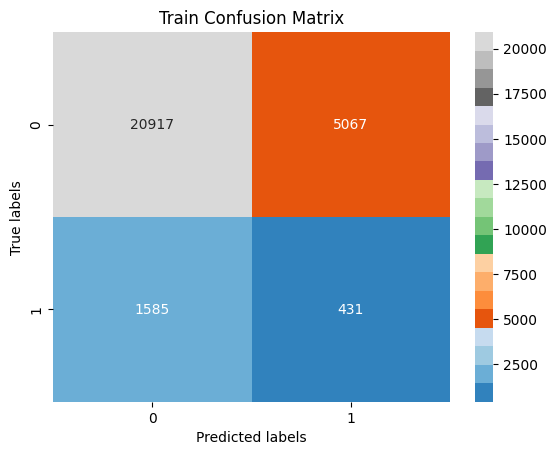

In [ ]:
cm_train = metrics.confusion_matrix(y_train, pred_train)

ax= plt.subplot()
sns.heatmap(cm_train, cmap='tab20c', annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Train Confusion Matrix');

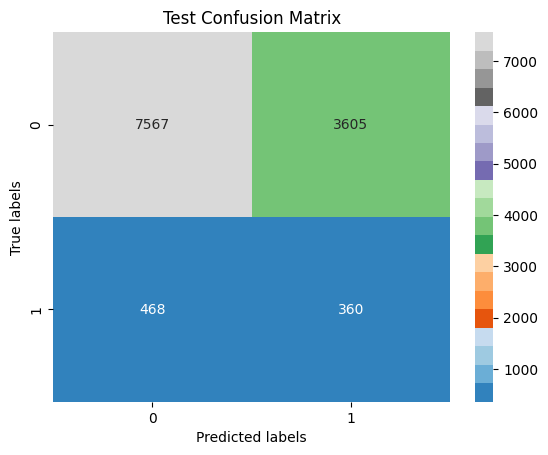

In [ ]:
cm_test = metrics.confusion_matrix(y_test, pred_test)

ax= plt.subplot()
sns.heatmap(cm_test, cmap='tab20c', annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Test Confusion Matrix');

In [ ]:
print('Train accuracy score: ', metrics.accuracy_score(y_train, pred_train))
print('Test accuracy score: ', metrics.accuracy_score(y_test, pred_test))
print('Train recall score: ', metrics.recall_score(y_train, pred_train))
print('Test recall score: ', metrics.recall_score(y_test, pred_test))
print('Train AUC score: ', metrics.roc_auc_score(y_train, pred_train))
print('Test AUC score: ', metrics.roc_auc_score(y_test, pred_test))

Train accuracy score:  0.69475
Test accuracy score:  0.6605833333333333
Train recall score:  0.7253384912959381
Test recall score:  0.43478260869565216
Train AUC score:  0.7088245749708134
Test AUC score:  0.5560504522175003


# Parameters tuning

In [ ]:
param_grid = {'max_depth': [2, 4, 6, 8],               # default 6
              'subsample': [0.95, 1],               # default 1
              'colsample_bytree': [0.5, 0.7, 0.9, 1],   # default 1
              'min_child_weight': [5, 10, 20, 50],       # default 1
              'n_estimators': [200, 500, 1000],       # default 100
              'learning_rate': [0.01, 0.1, 0.3],    # default 0.3
              'scale_pos_weight': [spw],
              'random_state': [42]}

In [ ]:
xgb = xgboost.XGBClassifier()
clf = model_selection.RandomizedSearchCV(xgb, param_grid, n_iter=10, scoring='recall', verbose=1, return_train_score=True, random_state=29)
clf.fit(X_train, y_train)

cv_results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
col_of_interest = ['param_max_depth',
                   'param_subsample',
                   'param_colsample_bytree',
                   'param_min_child_weight',
                   'param_n_estimators',
                   'param_learning_rate',
                   'param_scale_pos_weight',
                   'rank_test_score',
                   'mean_test_score',
                   'mean_train_score']
relevant_values = cv_results[col_of_interest]
relevant_values.sort_values(by=['mean_test_score', 'mean_train_score'], ascending=False)

,param_max_depth,param_subsample,param_colsample_bytree,param_min_child_weight,param_n_estimators,param_learning_rate,param_scale_pos_weight,rank_test_score,mean_test_score,mean_train_score
5,6,0.95,1,10,500,0.01,12.812155,1,0.793540,0.860494
7,8,0.95,0.5,50,1000,0.01,12.812155,2,0.773711,0.875363
4,8,1,0.7,5,200,0.01,12.812155,3,0.764527,0.877055
9,4,1,1,20,200,0.3,12.812155,4,0.758239,0.895309
3,2,0.95,1,5,200,0.01,12.812155,5,0.746608,0.746615
0,4,0.95,0.5,50,500,0.3,12.812155,6,0.737427,0.911992
2,4,0.95,0.9,20,1000,0.3,12.812155,7,0.633943,0.972800
8,6,1,0.5,5,200,0.3,12.812155,8,0.629112,0.969415
6,6,1,0.9,5,500,0.1,12.812155,9,0.624769,0.968206
1,4,1,0.7,5,1000,0.3,12.812155,10,0.600094,0.968811


In [ ]:
param_grid = {'reg_lambda': [0, 1, 5],
              'reg_alpha': [0, 1, 5],
              'max_depth': [6, 8, 10],
              'subsample': [0.8, 0.95, 1],
              'colsample_bytree': [0.7, 0.9, 1],
              'min_child_weight': [10, 20, 50],
              'n_estimators': [500, 700, 1000],
              'learning_rate': [0.01, 0.02, 0.05],
              'scale_pos_weight': [spw],
              'random_state': [42]}

xgb = xgboost.XGBClassifier()
clf = model_selection.RandomizedSearchCV(xgb, param_grid, n_iter=10, scoring='accuracy', verbose=1, return_train_score=True, random_state=29)
clf.fit(X_train, y_train)

cv_results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [ ]:
col_of_interest = ['param_reg_lambda',
                   'param_reg_alpha',
                   'param_max_depth',
                   'param_subsample',
                   'param_colsample_bytree',
                   'param_min_child_weight',
                   'param_n_estimators',
                   'param_learning_rate',
                   'param_scale_pos_weight',
                   'rank_test_score',
                   'mean_test_score',
                   'mean_train_score']
relevant_values = cv_results[col_of_interest]
relevant_values.sort_values(by=['mean_test_score', 'mean_train_score'], ascending=False)

,param_reg_lambda,param_reg_alpha,param_max_depth,param_subsample,param_colsample_bytree,param_min_child_weight,param_n_estimators,param_learning_rate,param_scale_pos_weight,rank_test_score,mean_test_score,mean_train_score
0,5,0,10,1,1,10,1000,0.05,12.812155,1,0.886179,0.958286
13,5,0,8,0.95,1,10,1000,0.05,12.812155,2,0.881607,0.947241
11,0,5,8,0.95,0.9,10,700,0.05,12.812155,3,0.872607,0.923893
8,5,5,8,1,1,10,500,0.05,12.812155,4,0.861286,0.904098
10,1,5,10,1,0.9,10,500,0.02,12.812155,5,0.860179,0.897170
2,0,0,10,0.8,0.9,50,1000,0.02,12.812155,6,0.847321,0.875554
12,0,0,8,0.95,1,50,500,0.05,12.812155,7,0.847250,0.878018
9,5,1,10,1,0.9,20,500,0.01,12.812155,8,0.845321,0.865563
4,0,0,6,0.8,0.7,20,1000,0.02,12.812155,9,0.844643,0.867795
3,5,5,6,0.95,0.7,10,1000,0.02,12.812155,10,0.842179,0.865125


In [ ]:
print('The parameters combination that would give best accuracy is : ')
print(clf.best_params_)
print('The best accuracy achieved after parameter tuning via grid search is : ', clf.best_score_)

The parameters combination that would give best accuracy is : 
{'subsample': 1, 'scale_pos_weight': 12.812154696132596, 'reg_lambda': 5, 'reg_alpha': 0, 'random_state': 42, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1}
The best accuracy achieved after parameter tuning via grid search is :  0.8861785714285715


In [ ]:
xgb = xgboost.XGBClassifier(**clf.best_params_)
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric=['error', 'logloss'], verbose=True)

pred_train = xgb.predict(X_train)
pred_test = xgb.predict(X_test)

In [ ]:
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

In [ ]:
from matplotlib import pyplot

accuracy_train = np.ones_like(results['validation_0']['error']) - results['validation_0']['error']
accuracy_test = np.ones_like(results['validation_1']['error']) - results['validation_1']['error']

px.line(x=x_axis, y=[accuracy_train, accuracy_test], title='Train and Test accuracy over training epochs', labels={'value': 'accuracy', 'x': 'epochs'})

In [ ]:
px.line(x=x_axis, y=[results['validation_0']['logloss'], results['validation_1']['logloss']], title='Train and Test Negative Log-likelihood over training epochs', labels={'value': 'logloss', 'x': 'epochs'})

In [ ]:
print('Train accuracy score: ', metrics.accuracy_score(y_train, pred_train))
print('Test accuracy score: ', metrics.accuracy_score(y_test, pred_test))
print('Train recall score: ', metrics.recall_score(y_train, pred_train))
print('Test recall score: ', metrics.recall_score(y_test, pred_test))
print('Train AUC score: ', metrics.roc_auc_score(y_train, pred_train))
print('Test AUC score: ', metrics.roc_auc_score(y_test, pred_test))

Train accuracy score:  0.86775
Test accuracy score:  0.77825
Train recall score:  0.9680851063829787
Test recall score:  0.2391304347826087
Train AUC score:  0.9139168397872012
Test AUC score:  0.5286683323214869


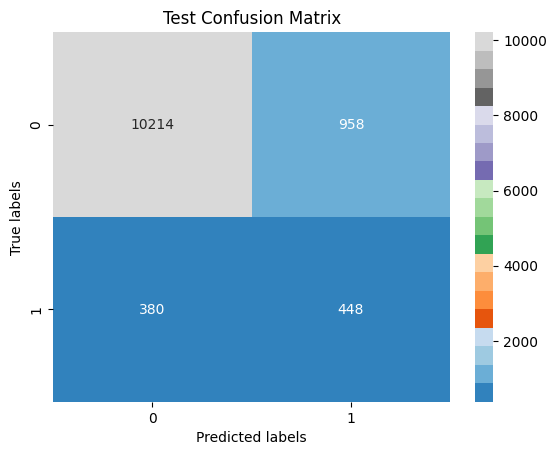

In [ ]:
cm_test = metrics.confusion_matrix(y_test, pred_test)

ax= plt.subplot()
sns.heatmap(cm_test, cmap='tab20c', annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Test Confusion Matrix');

In [ ]:
importance = {}
sorted_importance = {}

cont = 0
for feature in attributes.keys():

  importance[feature] = xgb.feature_importances_[cont]
  cont+=1

for key in sorted(importance, key=importance.get, reverse=True):
   sorted_importance[key] = importance[key]

fig = px.bar(x=sorted_importance.keys(), y=sorted_importance, title='Feature importance')
fig.update_xaxes(tickangle=80)

# 5-Fold Cross Validation

In [ ]:
xgb = xgboost.XGBClassifier(min_child_weight=10,
                            max_depth=4,
                            n_estimators=200,
                            scale_pos_weight=spw,
                            random_state=42)

# xgb = xgboost.XGBClassifier(**clf.best_params_)
output = model_selection.cross_validate(xgb, attributes, labels, scoring=['accuracy', 'recall'], cv=5, return_train_score=True, return_estimator=True)

In [ ]:
print('Train accuracy score: ', output['train_accuracy'].mean())
print('Test accuracy score: ', output['test_accuracy'].mean())
print('Train recall score: ', output['train_recall'].mean())
print('Test recall score: ', output['test_recall'].mean())

Train accuracy score:  0.8549000000000001
Test accuracy score:  0.7263249999999999
Train recall score:  0.886308638634766
Test recall score:  0.6939550949913643


# Partial Dependence Plot

In [15]:
spw = (labels == 0).sum() / labels.sum()

In [ ]:
# check Notes_3 for the reason why we use the initial parameters tuning:
# even if Tuning is carried out to maximise the recall, the 5-fold cross validation recall of the tuned model is 15% lower than with the inizial parameters
best_params = {'min_child_weight': 10,
               'max_depth': 4,
               'n_estimators': 200,
               'scale_pos_weight': spw,
               'random_state': 42}

xgb = xgboost.XGBClassifier(**best_params)
xgb.fit(X_train, y_train)

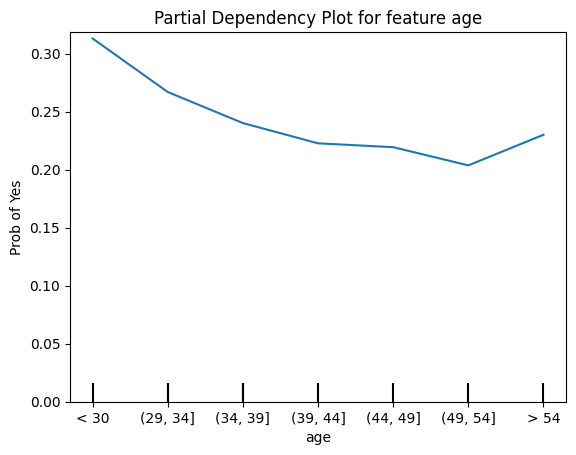

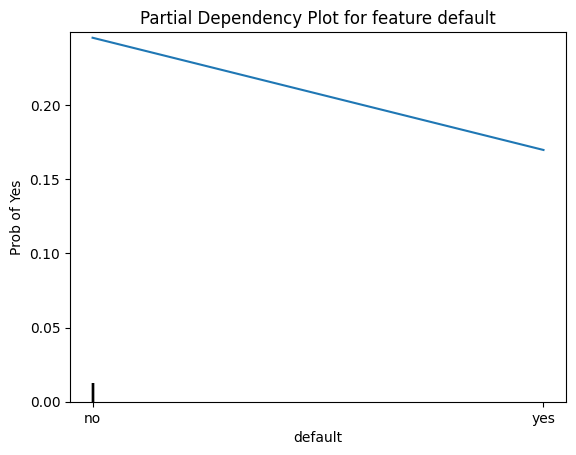

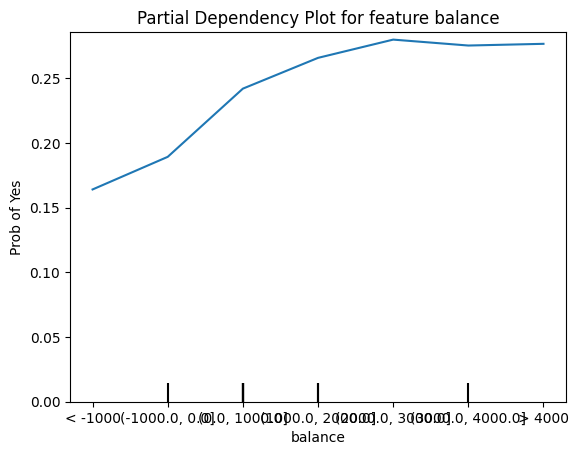

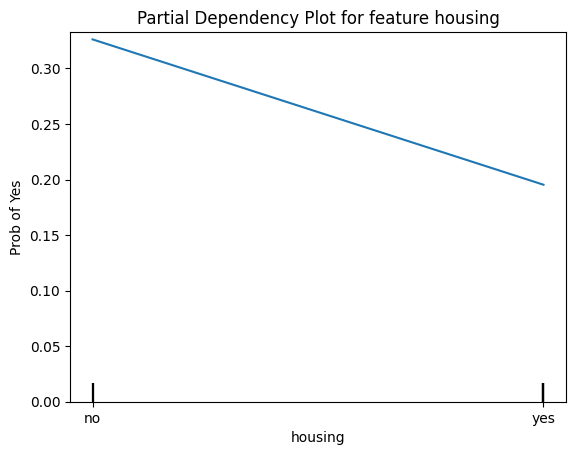

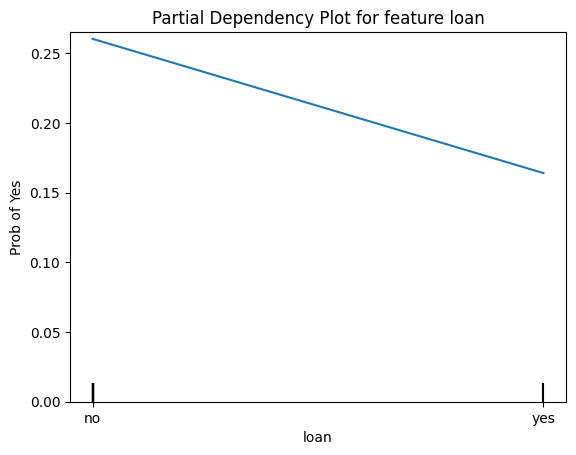

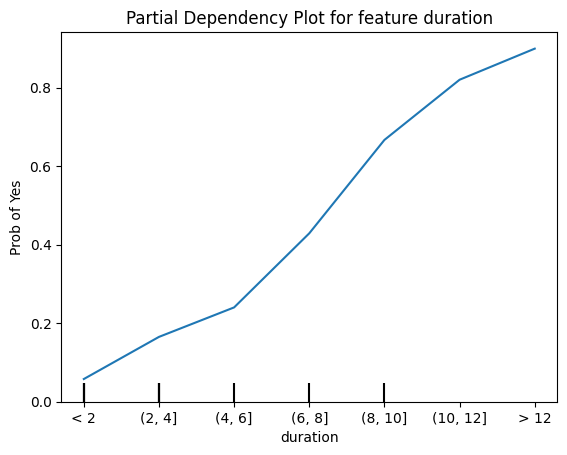

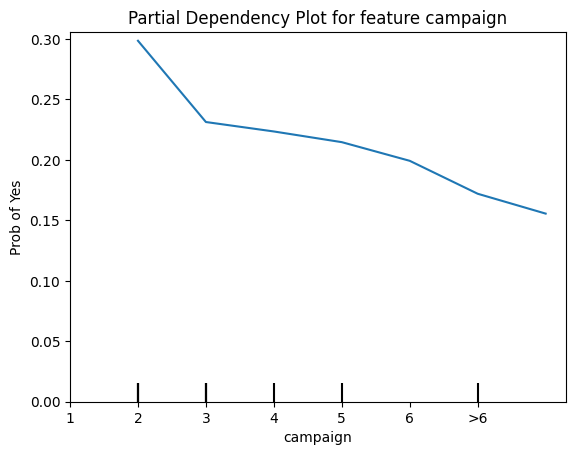

In [39]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

features = ['age', 'default', 'balance', 'housing', 'loan', 'duration', 'campaign']

x_ticks = {'age': ["< 30", "(29, 34]", "(34, 39]", "(39, 44]", "(44, 49]", "(49, 54]", "> 54"],
           'duration': ['< 2', '(2, 4]', '(4, 6]', '(6, 8]', '(8, 10]', '(10, 12]', '> 12'],
           'balance': ['< -1000', '(-1000.0, 0.0]', '(0.0, 1000.0]', '(1000.0, 2000.0]', '(2000.0, 3000.0]', '(3000.0, 4000.0]', '> 4000'],
           'campaign': ['1', '2', '3', '4', '5', '6', '>6']}

for feature in features:

  PartialDependenceDisplay.from_estimator(xgb, attributes, [feature])
  plt.title(f'Partial Dependency Plot for feature {feature}')
  plt.ylabel('Prob of Yes')

  if feature not in x_ticks.keys():
    plt.xticks(ticks=[0.0, 1.0], labels=['no', 'yes'])

  else:
    plt.xticks(ticks=np.arange(len(x_ticks[feature])), labels=x_ticks[feature])

  plt.ylim(bottom=0.0)
  plt.show()

In [40]:
mod_attributes = attributes.copy()

,age,default,balance,housing,loan,duration,campaign,job - business jobs,job - low skills,job - management,...,contact - cellular,contact - telephone,contact - unknown,day - after_payday,day - non_payday,day - payday,month - fall,month - spring,month - summer,month - winter
17159,5.0,1,0.0,0,1,1.0,6,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
12909,0.0,1,0.0,0,1,2.0,3,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
31509,5.0,0,0.0,1,1,2.0,1,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
38736,6.0,0,0.0,1,0,2.0,6,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
15682,4.0,1,0.0,0,1,1.0,1,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


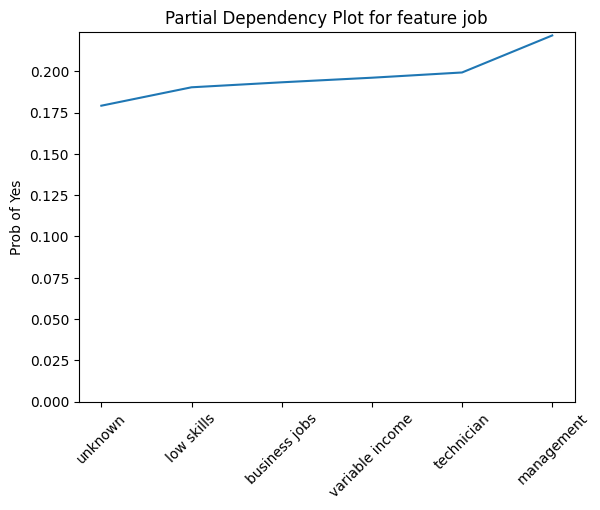

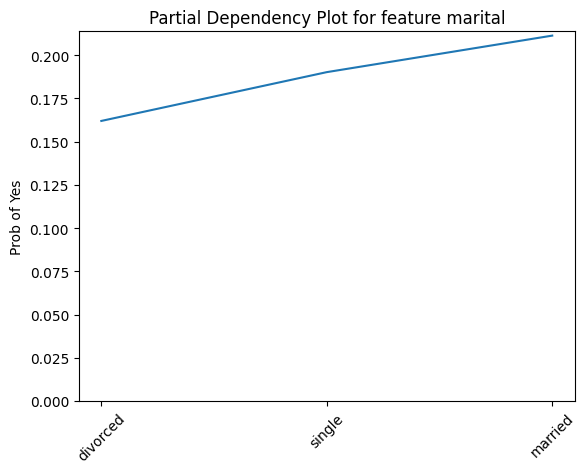

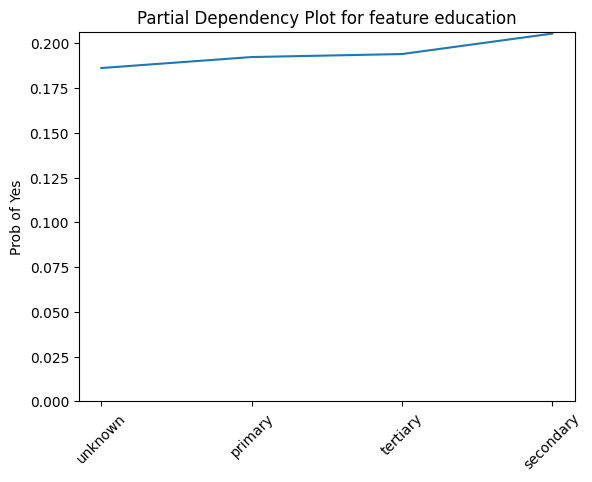

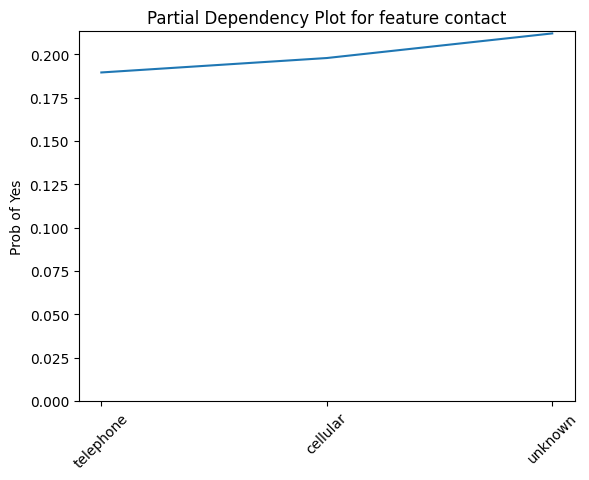

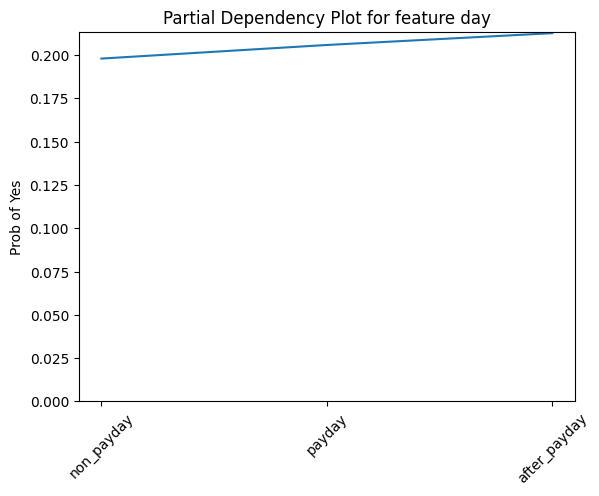

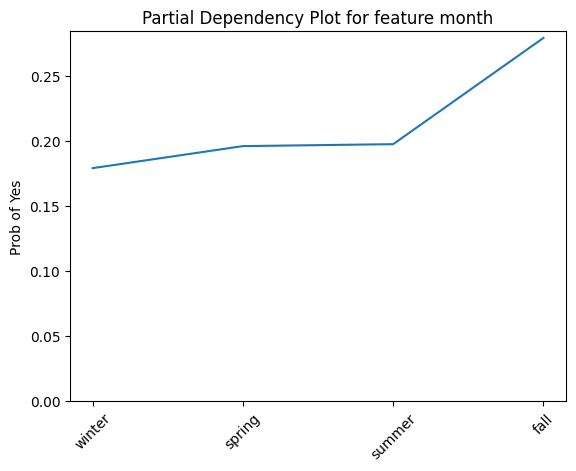

In [63]:
# Categorical features encoded as One Hot
job = ['job - business jobs', 'job - low skills', 'job - management', 'job - technician', 'job - unknown', 'job - variable income']
marital = ['marital - divorced', 'marital - married', 'marital - single']
education = ['education - primary', 'education - secondary', 'education - tertiary', 'education - unknown']
contact = ['contact - cellular', 'contact - telephone', 'contact - unknown']
day = ['day - after_payday', 'day - non_payday', 'day - payday']
month = ['month - fall', 'month - spring', 'month - summer', 'month - winter']

categorical_features = [job, marital, education, contact, day, month]

for cat_feat in categorical_features:
  # reset the attributes
  mod_attributes = attributes.copy()

  # set all categories to zero
  for col in cat_feat:
    mod_attributes[col] = 0.0

  # Dictionary to store the probability of yes
  results = {}

  # Do the actual work:
  for cat in cat_feat:
    # Set one column to 1
    mod_attributes[cat] = 1.0

    # Compute the predictions, and store the mean in the dict
    pred = xgb.predict(mod_attributes)
    cat_name = cat.split(' - ')[1]
    results[cat_name] = pred.mean()

    # reset the category back to zero
    mod_attributes[cat] = 0.0

  # sort the results in ascending order
  results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1])}

  # plot and make it pretty
  plt.plot([*results.values()])
  feature_name = cat.split(' - ')[0]
  plt.title(f'Partial Dependency Plot for feature {feature_name}')
  plt.ylabel('Prob of Yes')
  plt.ylim(bottom=0.0)
  plt.xticks(ticks=np.arange(len(results.keys())), labels=results.keys(), rotation=45)
  plt.show()